In [1]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn import tree
import xgboost as xgb

In [2]:
data = pd.read_csv("train-chennai-sale.csv")
pd.set_option('display.max_columns', None)
data.head(3)

PRT_ID        AREA  INT_SQFT   DATE_SALE  DIST_MAINROAD  N_BEDROOM  \
0  P03210  Karapakkam      1004  04-05-2011            131        1.0   
1  P09411  Anna Nagar      1986  19-12-2006             26        2.0   
2  P01812       Adyar       909  04-02-2012             70        1.0   

   N_BATHROOM  N_ROOM SALE_COND PARK_FACIL  DATE_BUILD   BUILDTYPE  \
0         1.0       3  AbNormal        Yes  15-05-1967  Commercial   
1         1.0       5  AbNormal         No  22-12-1995  Commercial   
2         1.0       3  AbNormal        Yes  09-02-1992  Commercial   

  UTILITY_AVAIL  STREET MZZONE  QS_ROOMS  QS_BATHROOM  QS_BEDROOM  QS_OVERALL  \
0        AllPub   Paved      A       4.0          3.9         4.9       4.330   
1        AllPub  Gravel     RH       4.9          4.2         2.5       3.765   
2           ELO  Gravel     RL       4.1          3.8         2.2       3.090   

   REG_FEE  COMMIS  SALES_PRICE  
0   380000  144400      7600000  
1   760122  304049     21717770  
2   421094   92114     13159200

## Data Cleaning

In [3]:
# Removing all the null values
data.dropna(inplace=True)

# Renaming all the column names in lowercase letters
data.columns = data.columns.str.lower()


# Renaming all the string in area column names in lowercase letters
data.area = data.area.str.lower()

# Correcting the spelling mistakes in area columns
data.area = data.area.replace({'velchery':'velachery', 
                       'kknagar':'kk nagar', 
                       'tnagar':'t nagar', 
                       'chormpet':'chrompet', 
                       'chrompt':'chrompet', 
                       'chrmpet':'chrompet', 
                       'ana nagar':'anna nagar', 
                       'ann nagar':'anna nagar',
                       'karapakam':'karapakkam', 
                       'adyr':'adyar'})


# Renaming all the string in sale_cond column names in lowercase letters
data.sale_cond = data.sale_cond.str.lower()

# Correcting the spelling mistakes in sale_cond columns
data.sale_cond = data.sale_cond.replace({'adj land':'adjland', 
                       'normal sale':'normal sale',
                       'partiall':'partial',
                       'ab normal':'abnormal'})


# Renaming all the string in park_facil column names in lowercase letters
data.park_facil = data.park_facil.str.lower()

# Correcting the spelling mistakes in park_facil columns
data.park_facil = data.park_facil.replace({'noo':'no'})


# Renaming all the string in buildtype column names in lowercase letters
data.buildtype = data.buildtype.str.lower()

# Correcting the spelling mistakes in buildtype columns
data.buildtype = data.buildtype.replace({'comercial':'commercial', 
                       'others':'other'})


# Renaming all the string in utility_avail column names in lowercase letters
data.utility_avail = data.utility_avail.str.lower()

# Correcting the spelling mistakes in utility_avail columns
data.utility_avail = data.utility_avail.replace({'all pub':'allpub',
                                             'nosewr':'nosewa'})
                                            
                                            
# Renaming all the string in street column names in lowercase letters
data.street = data.street.str.lower()

# Correcting the spelling mistakes in street columns
data.street = data.street.replace({'pavd':'paved', 
                       'noaccess':'no access'})


# Renaming all the string in mzzone column names in lowercase letters
data.mzzone = data.mzzone.str.lower()

# Fixing the correct Data Type of columns
data.n_bedroom = data.n_bedroom.astype(int)
data.n_bathroom = data.n_bathroom.astype(int)

# Correcting Date columnd from object to daterime format
data.date_sale = pd.to_datetime(data.date_sale, format='%d-%m-%Y')
data.date_build = pd.to_datetime(data.date_build, format='%d-%m-%Y')

# Creating property_age column which deternine how old the property id
data['property_age'] = pd.DatetimeIndex(data.date_sale).year - pd.DatetimeIndex(data.date_build).year

# Creating total_price column by adding 'reg_fee', 'commis', 'sales_price' columns
data['total_price'] = pd.DataFrame(data.reg_fee	+ data.commis	+ data.sales_price)

# Rearranging the columns of dataframe 
data = data.reindex(columns = ['prt_id', 'area', 'sale_cond', 'park_facil',
       'buildtype', 'utility_avail', 'street', 'mzzone', 
       'date_build', 'date_sale', 'property_age', 
       'int_sqft', 'dist_mainroad', 'n_bedroom','n_bathroom', 'n_room', 
       'qs_rooms', 'qs_bathroom', 'qs_bedroom', 'qs_overall', 
       'reg_fee', 'commis', 'sales_price', 'total_price'])

data.head(3)

prt_id        area sale_cond park_facil   buildtype utility_avail  street  \
0  P03210  karapakkam  abnormal        yes  commercial        allpub   paved   
1  P09411  anna nagar  abnormal         no  commercial        allpub  gravel   
2  P01812       adyar  abnormal        yes  commercial           elo  gravel   

  mzzone date_build  date_sale  property_age  int_sqft  dist_mainroad  \
0      a 1967-05-15 2011-05-04            44      1004            131   
1     rh 1995-12-22 2006-12-19            11      1986             26   
2     rl 1992-02-09 2012-02-04            20       909             70   

   n_bedroom  n_bathroom  n_room  qs_rooms  qs_bathroom  qs_bedroom  \
0          1           1       3       4.0          3.9         4.9   
1          2           1       5       4.9          4.2         2.5   
2          1           1       3       4.1          3.8         2.2   

   qs_overall  reg_fee  commis  sales_price  total_price  
0       4.330   380000  144400      7600000      8124400  
1       3.765   760122  304049     21717770     22781941  
2       3.090   421094   92114     13159200     13672408

## Exploratory Data Analysis

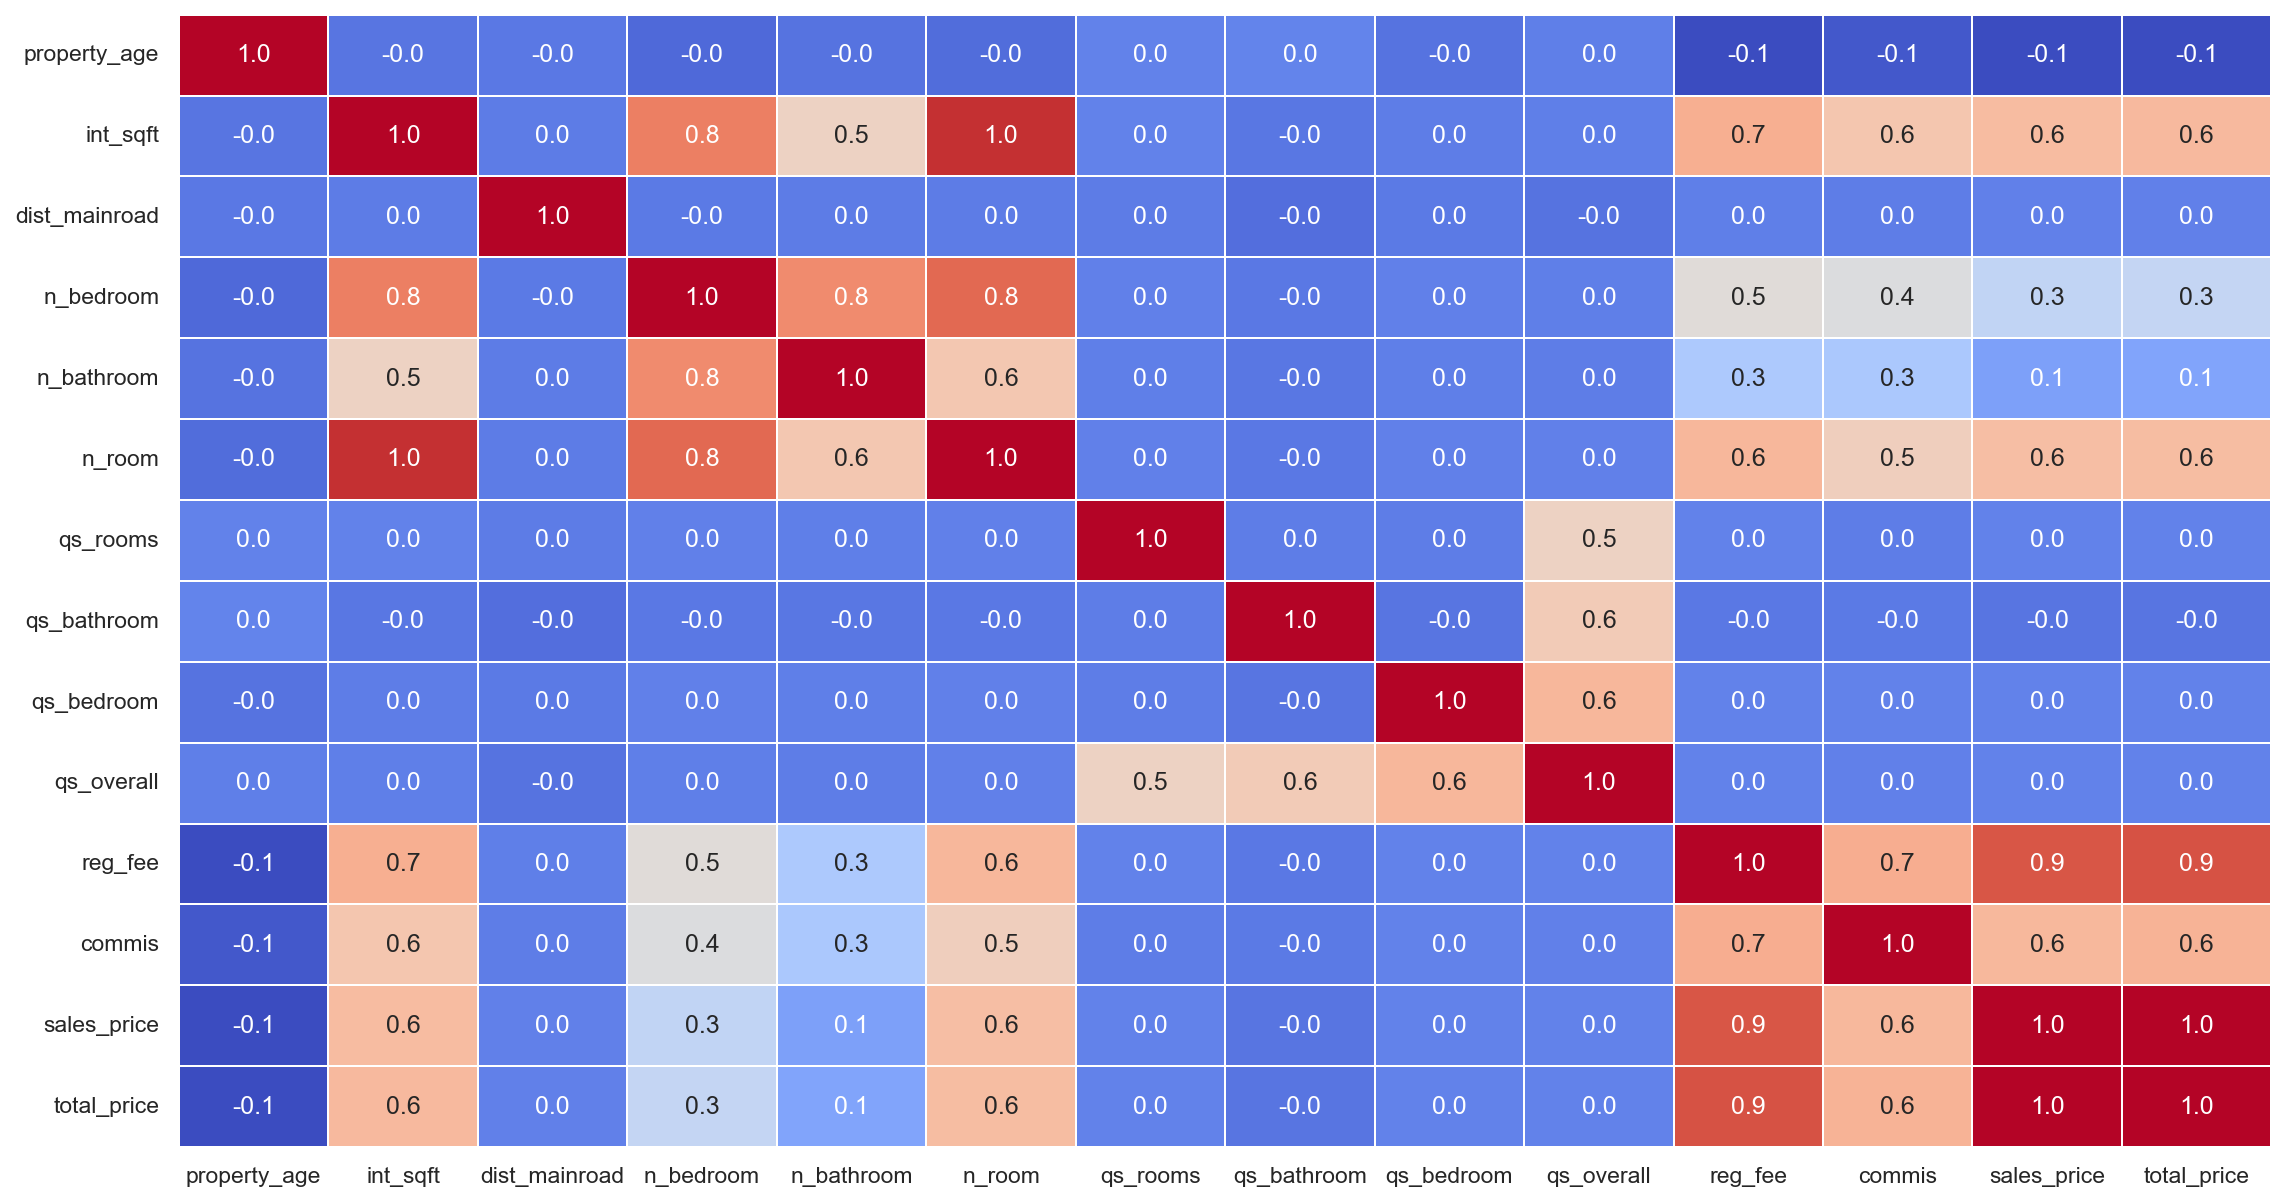

In [4]:
plt.figure(figsize=(18,10), dpi=150)
sns.heatmap(data.corr(method='pearson'), cbar=False, annot=True, fmt='.1f', linewidth=0.2, cmap='coolwarm');

#### Interpretation:-

Here as we can see that in numerical columns there are some correlation between target and features which are shown in red colour.

## Distribution Of Features in Data Columns

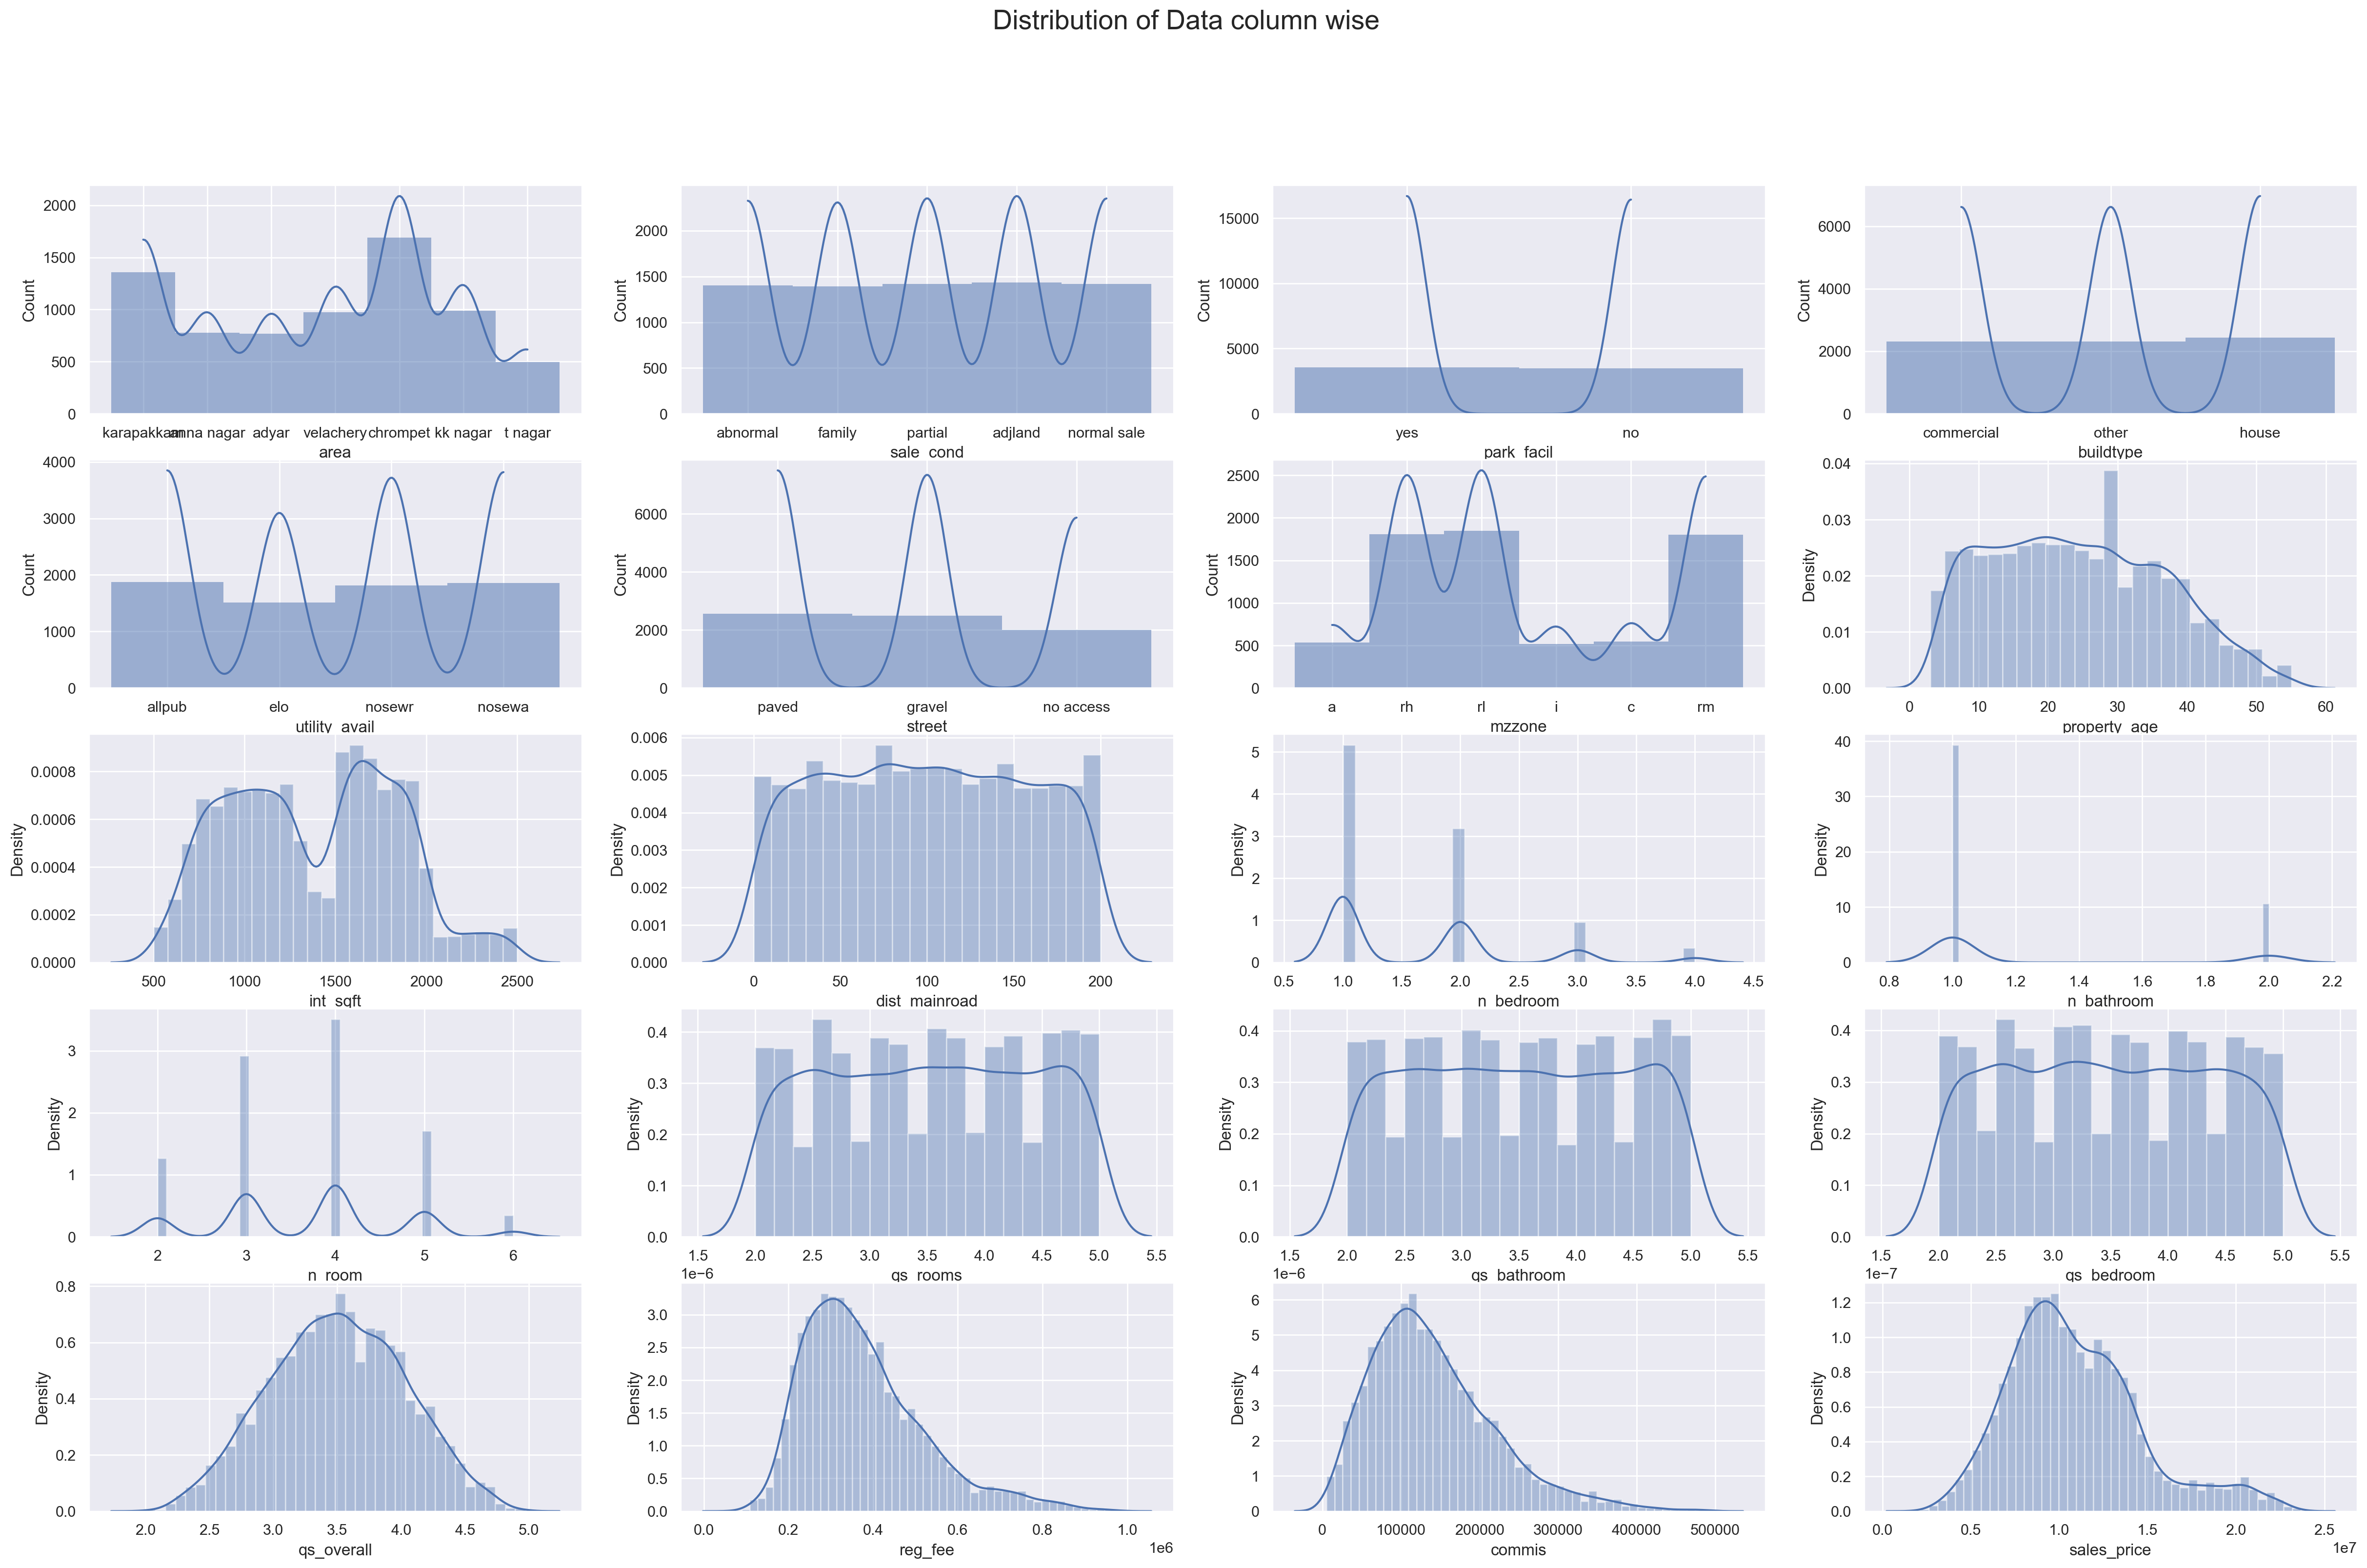

In [5]:
plt.figure(figsize=(30, 18), dpi=200)

plt.subplot(5,4,1)
sns.histplot(data.area, linewidth=0,kde=True)

plt.subplot(5,4,2)
sns.histplot(data.sale_cond, linewidth=0,kde=True)

plt.subplot(5,4,3)
sns.histplot(data.park_facil, linewidth=0,kde=True)

plt.subplot(5,4,4)
sns.histplot(data.buildtype, linewidth=0,kde=True)

plt.subplot(5,4,5)
sns.histplot(data.utility_avail, linewidth=0,kde=True)

plt.subplot(5,4,6)
sns.histplot(data.street, linewidth=0,kde=True)

plt.subplot(5,4,7)
sns.histplot(data.mzzone, linewidth=0,kde=True)

plt.subplot(5,4,8)
sns.distplot(data.property_age)

plt.subplot(5,4,9)
sns.distplot(data.int_sqft)

plt.subplot(5,4,10)
sns.distplot(data.dist_mainroad)

plt.subplot(5,4,11)
sns.distplot(data.n_bedroom)

plt.subplot(5,4,12)
sns.distplot(data.n_bathroom)

plt.subplot(5,4,13)
sns.distplot(data.n_room)

plt.subplot(5,4,14)
sns.distplot(data.qs_rooms)

plt.subplot(5,4,15)
sns.distplot(data.qs_bathroom)

plt.subplot(5,4,16)
sns.distplot(data.qs_bedroom)

plt.subplot(5,4,17)
sns.distplot(data.qs_overall)

plt.subplot(5,4,18)
sns.distplot(data.reg_fee)

plt.subplot(5,4,19)
sns.distplot(data.commis)

plt.subplot(5,4,20)
sns.distplot(data.sales_price)

plt.suptitle("Distribution of Data column wise", fontsize=20)
plt.show()

#### Interpretation:-

Here as we can see the distribution of data in all the columns are normally distributed in most of the cases and in very few column, the data is very slightly skewed.

## Plotting Features column vs Target column

### Numerical Columns

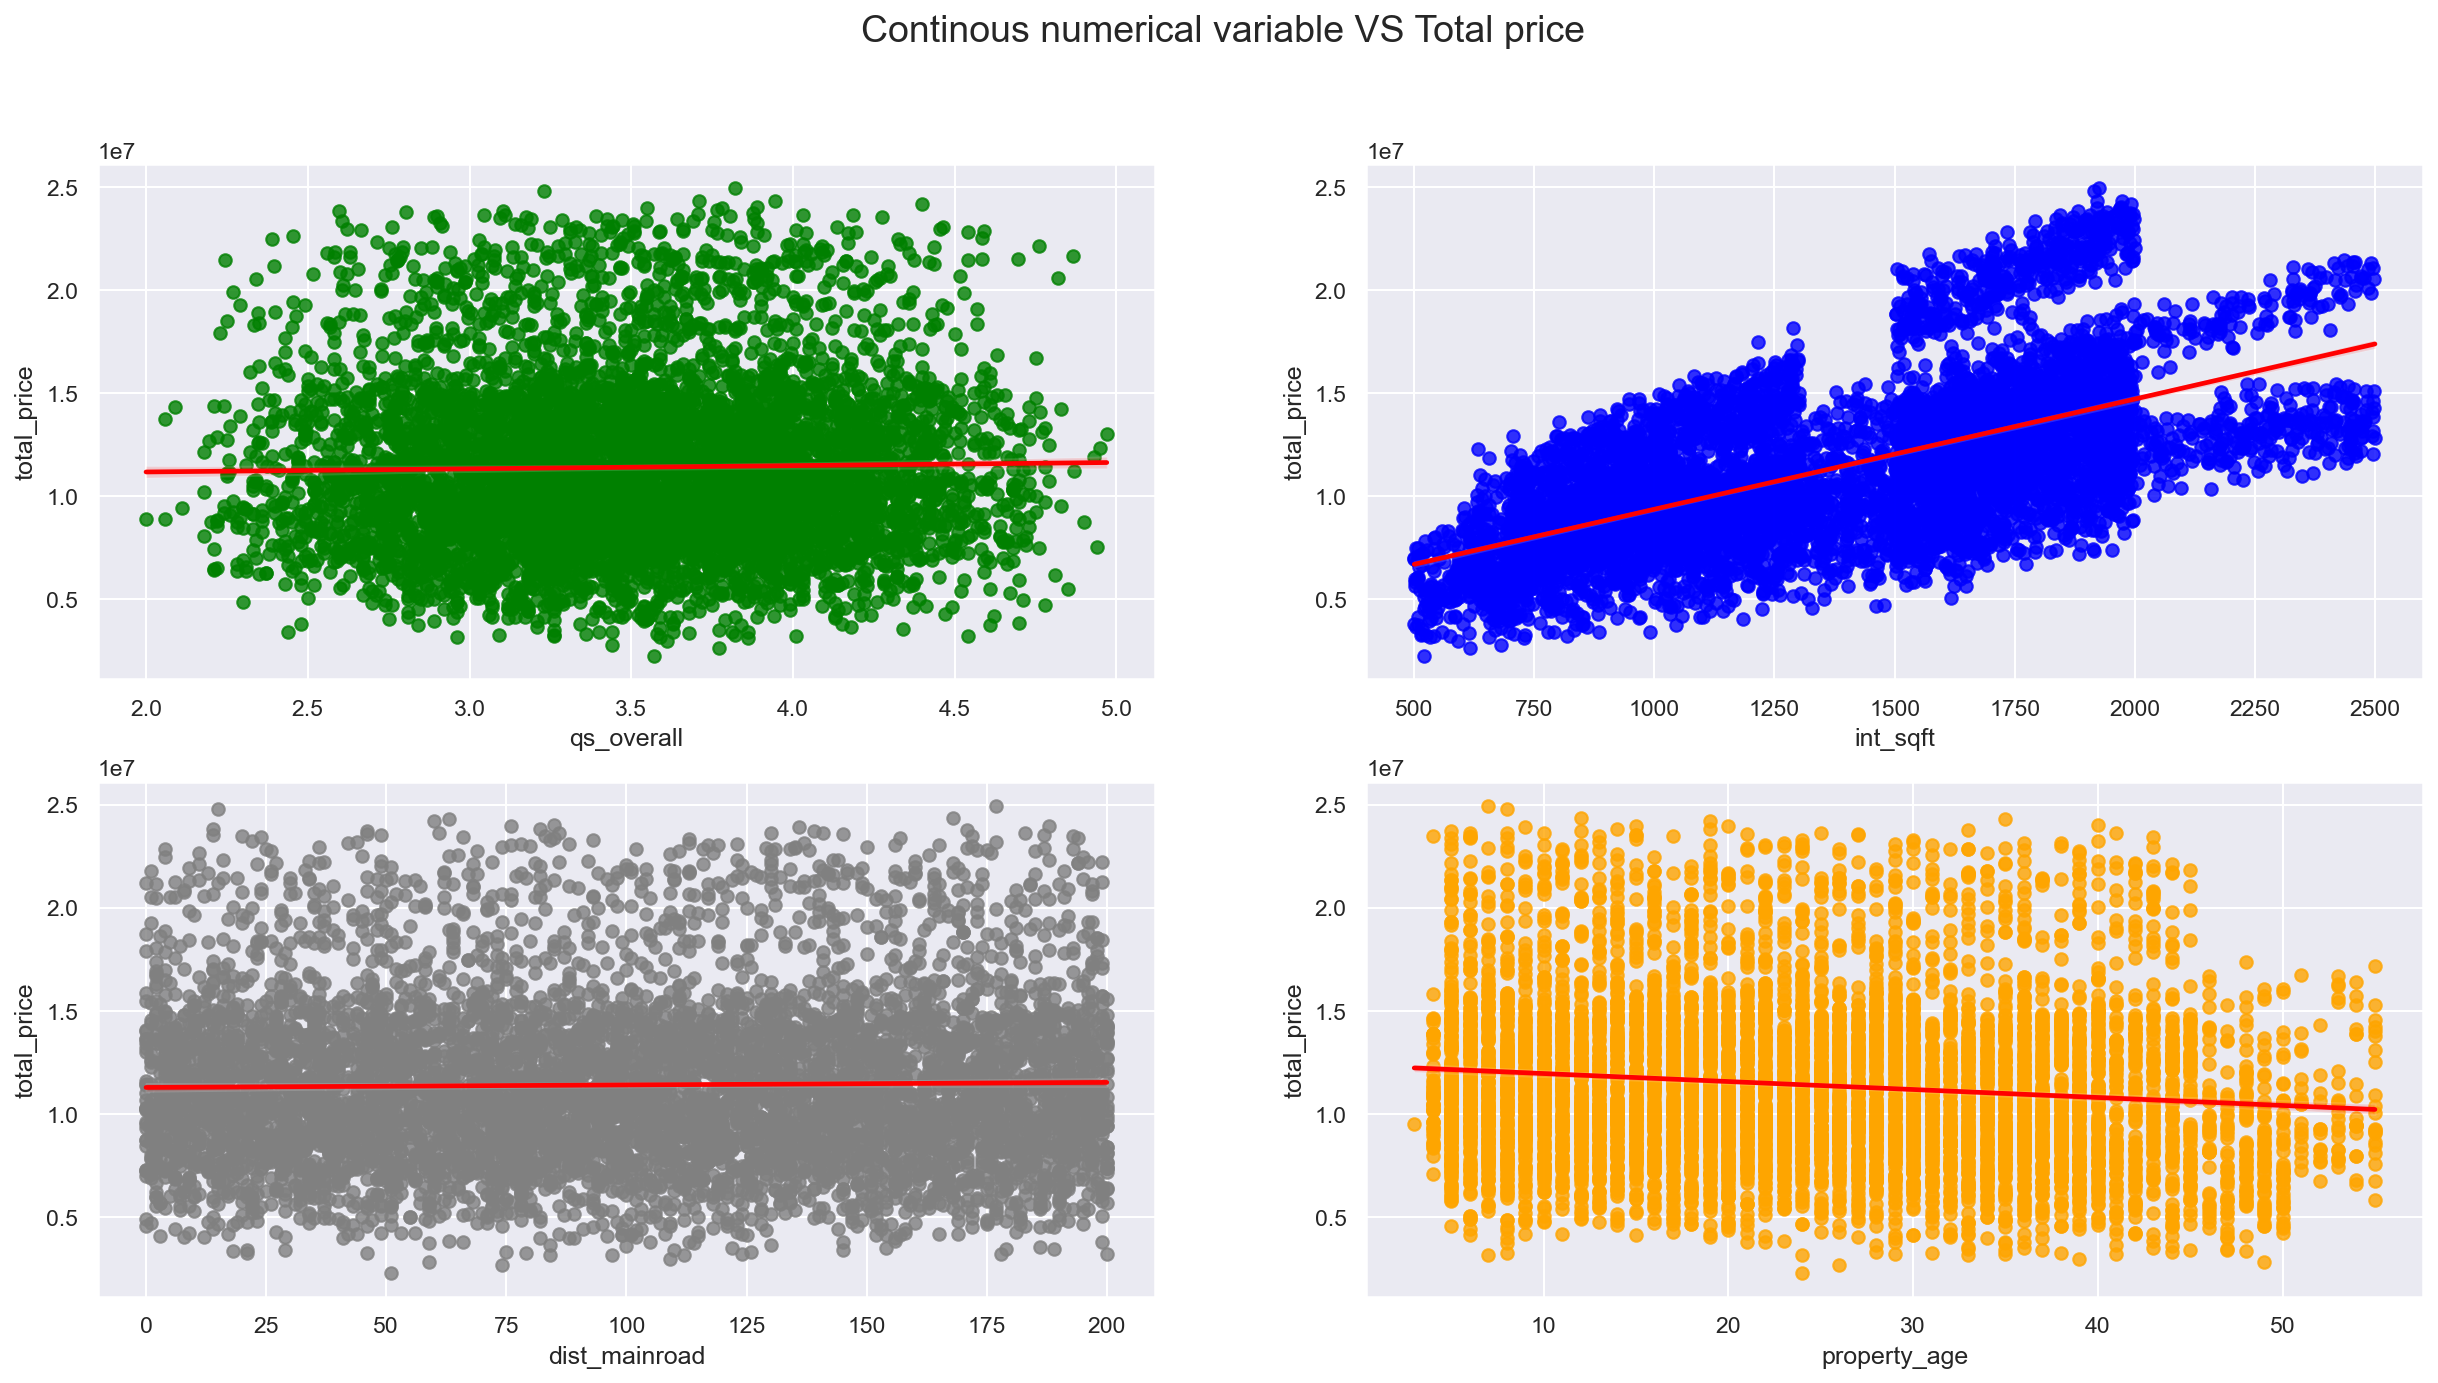

In [6]:
plt.figure(figsize=(20, 10), dpi=150)

plt.subplot(2,2,1)
sns.regplot(data.qs_overall, data.total_price, scatter_kws={"color": "green"}, line_kws={"color": "red"})

plt.subplot(2,2,2)
sns.regplot(data.int_sqft, data.total_price, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.subplot(2,2,3)
sns.regplot(data.dist_mainroad, data.total_price, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

plt.subplot(2,2,4)
sns.regplot(data.property_age, data.total_price, scatter_kws={"color": "orange"}, line_kws={"color": "red"})

plt.suptitle("Continous numerical variable VS Total price", fontsize=18)
plt.show()

#### Interpretation:-

Here we can come to conclusion that:

1. In qs_overall we didn't find any relation so this feature will be of no use or very less use for us so we will drop it.
2. In int_sqft we find good relation so this feature will be very important for us so we will keep it.
3. In dist_mainroad we didn't find any relation so this feature will be of no use or very less use for us so we will drop it.
4. In property_age we find small relation so this feature will be useful for us so we will keep it.

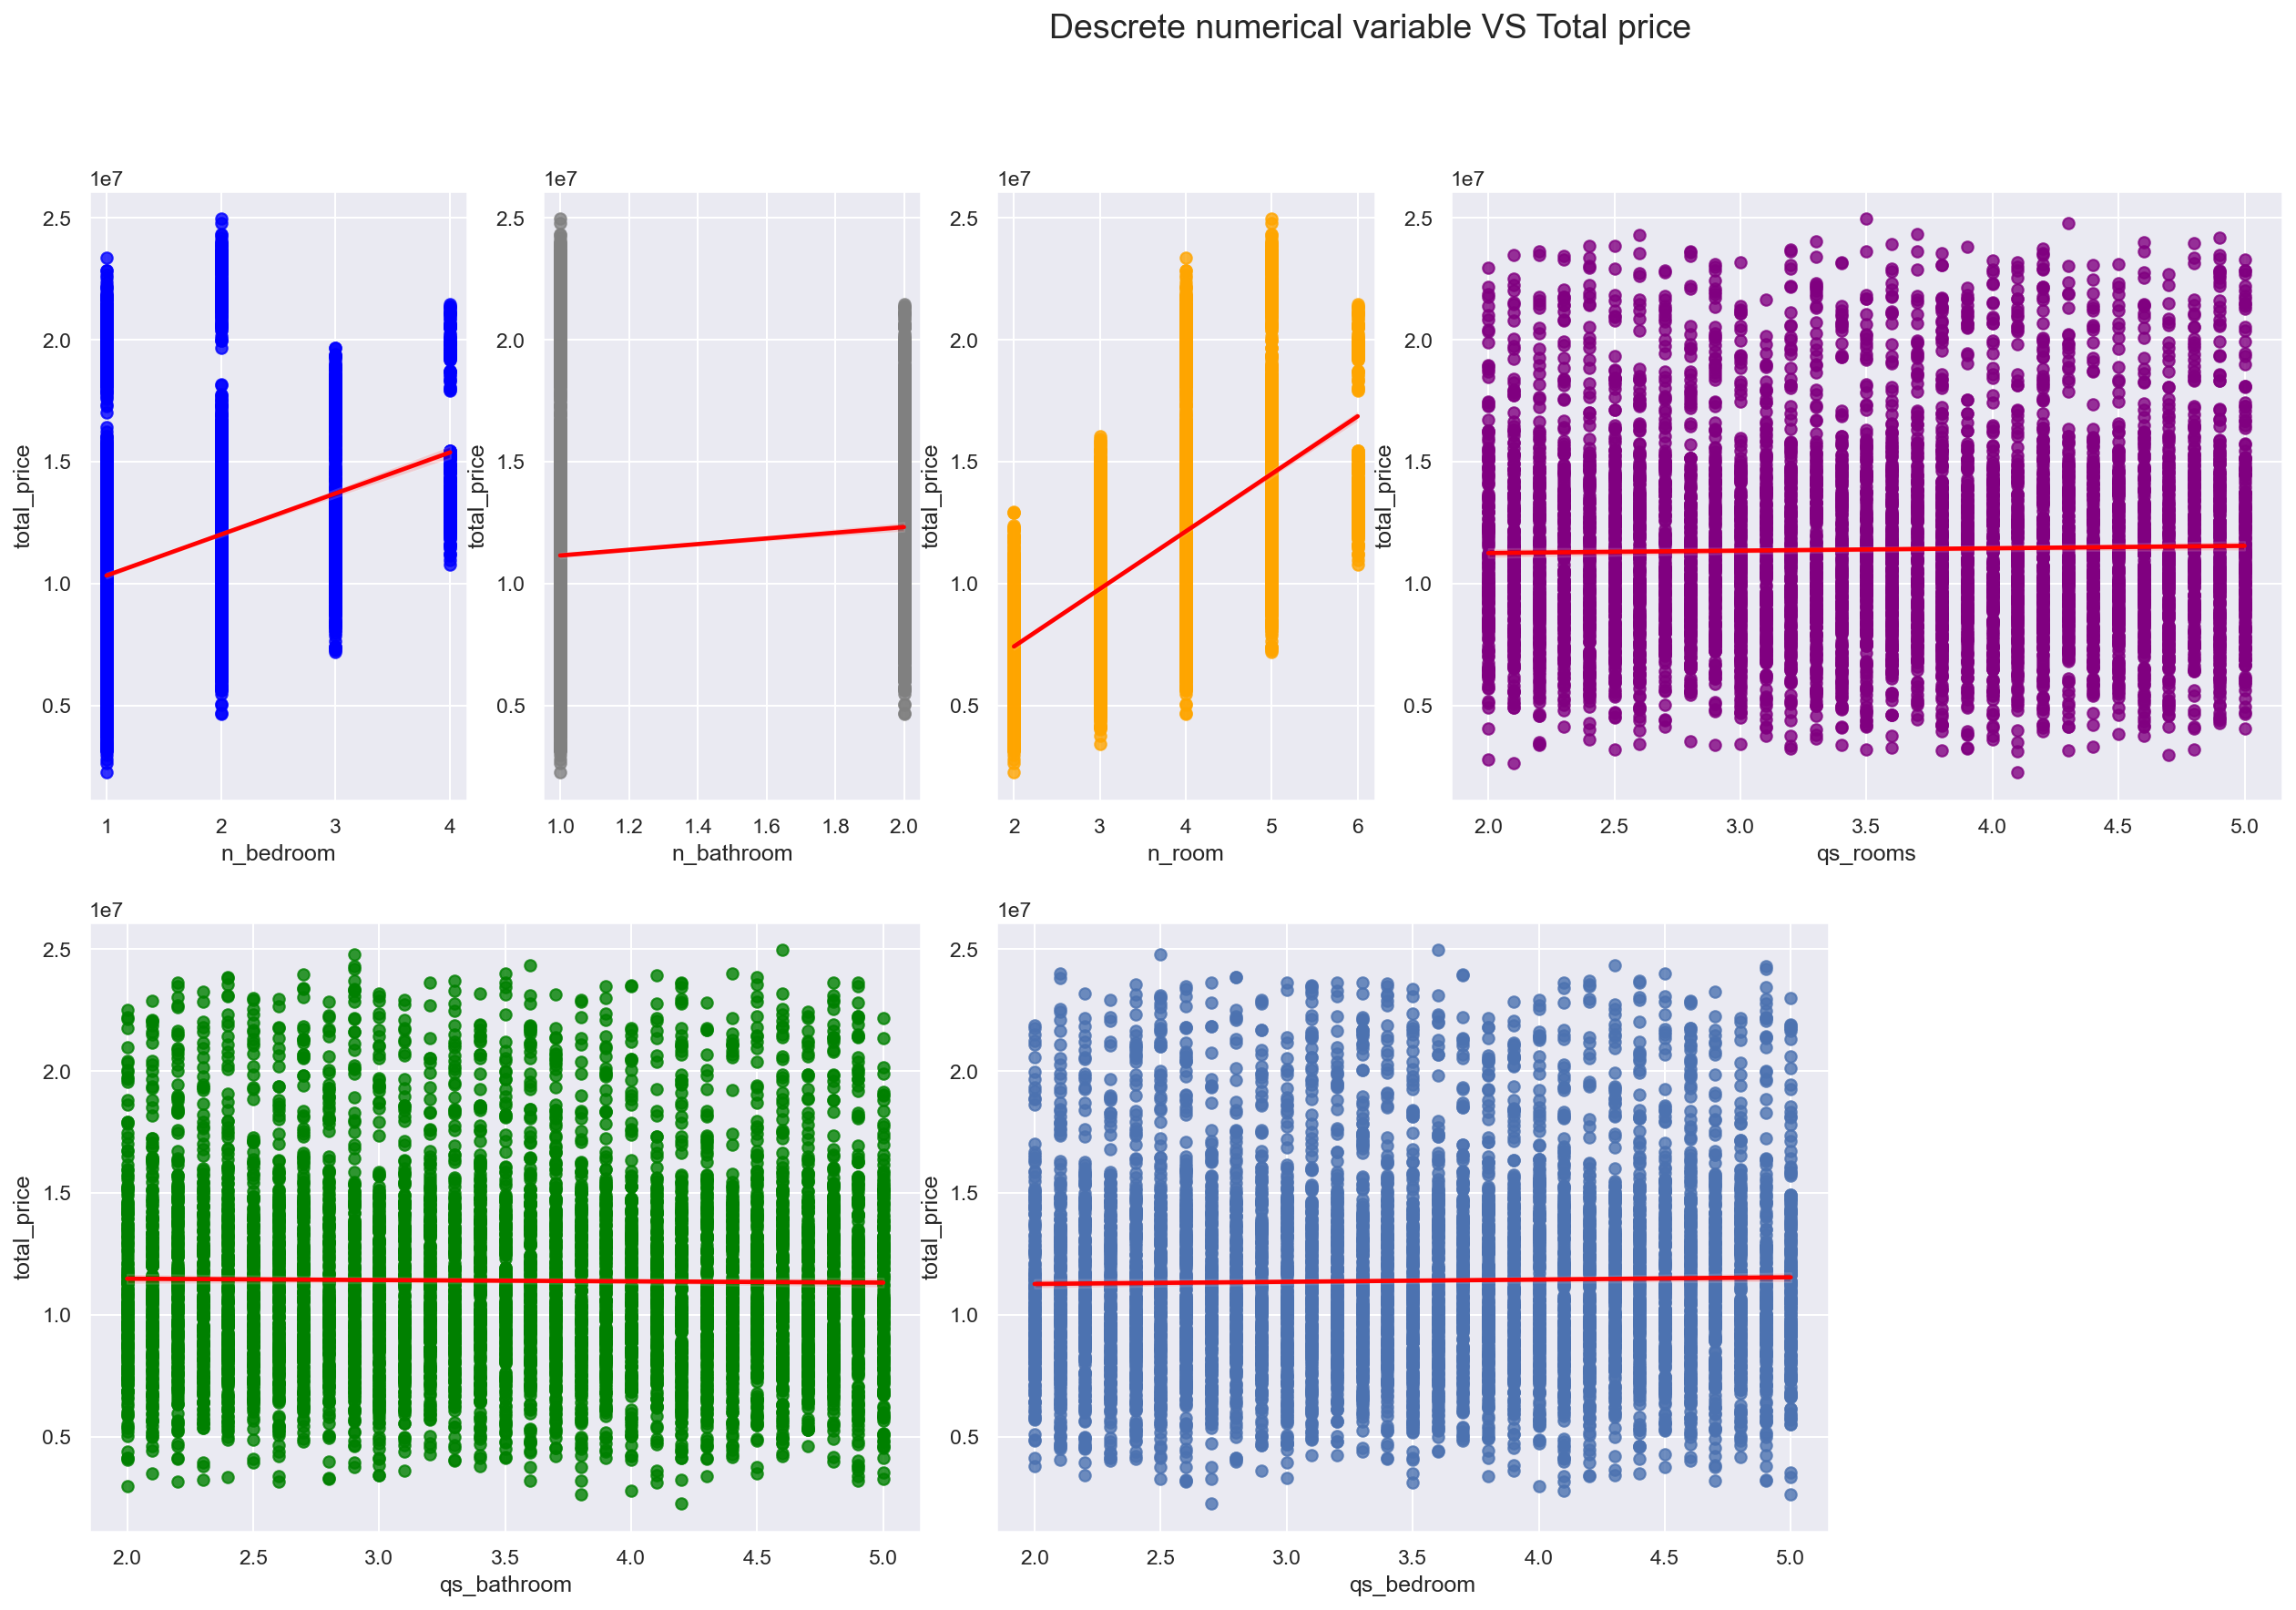

In [7]:
plt.figure(figsize=(25, 13), dpi=150)

plt.subplot2grid((2,6),(0,0))
sns.regplot(data.n_bedroom, data.total_price, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.subplot2grid((2,6),(0,1))
sns.regplot(data.n_bathroom, data.total_price, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

plt.subplot2grid((2,6),(0,2))
sns.regplot(data.n_room, data.total_price, scatter_kws={"color": "orange"}, line_kws={"color": "red"})

plt.subplot2grid((2,6),(0,3),colspan=2)
sns.regplot(data.qs_rooms, data.total_price, scatter_kws={"color": "purple"}, line_kws={"color": "red"})

plt.subplot2grid((2,6),(1,0),colspan=2)
sns.regplot(data.qs_bathroom, data.total_price, scatter_kws={"color": "green"}, line_kws={"color": "red"})

plt.subplot2grid((2,6),(1,2),colspan=2)
sns.regplot(data.qs_bedroom, data.total_price, line_kws={"color": "red"})

plt.suptitle("Descrete numerical variable VS Total price", fontsize=18)
plt.show()

#### Interpretation:-

Here we can come to conclusion that:

1. In n_bedroom we find good relation so this feature will be very important for us so we will keep it.
2. In n_bathroom we find small relation so this feature will be useful for us so we will keep it.
3. In n_room we find good relation so this feature will be very important for us so we will keep it.
4. In qs_rooms we didn't find any relation so this feature will be of no use or very less use for us so we will drop it.
5. In qs_bathroom we didn't find any relation so this feature will be of no use or very less use for us so we will drop it.
6. In qs_bedroom we didn't find any relation so this feature will be of no use or very less use for us so we will drop it.

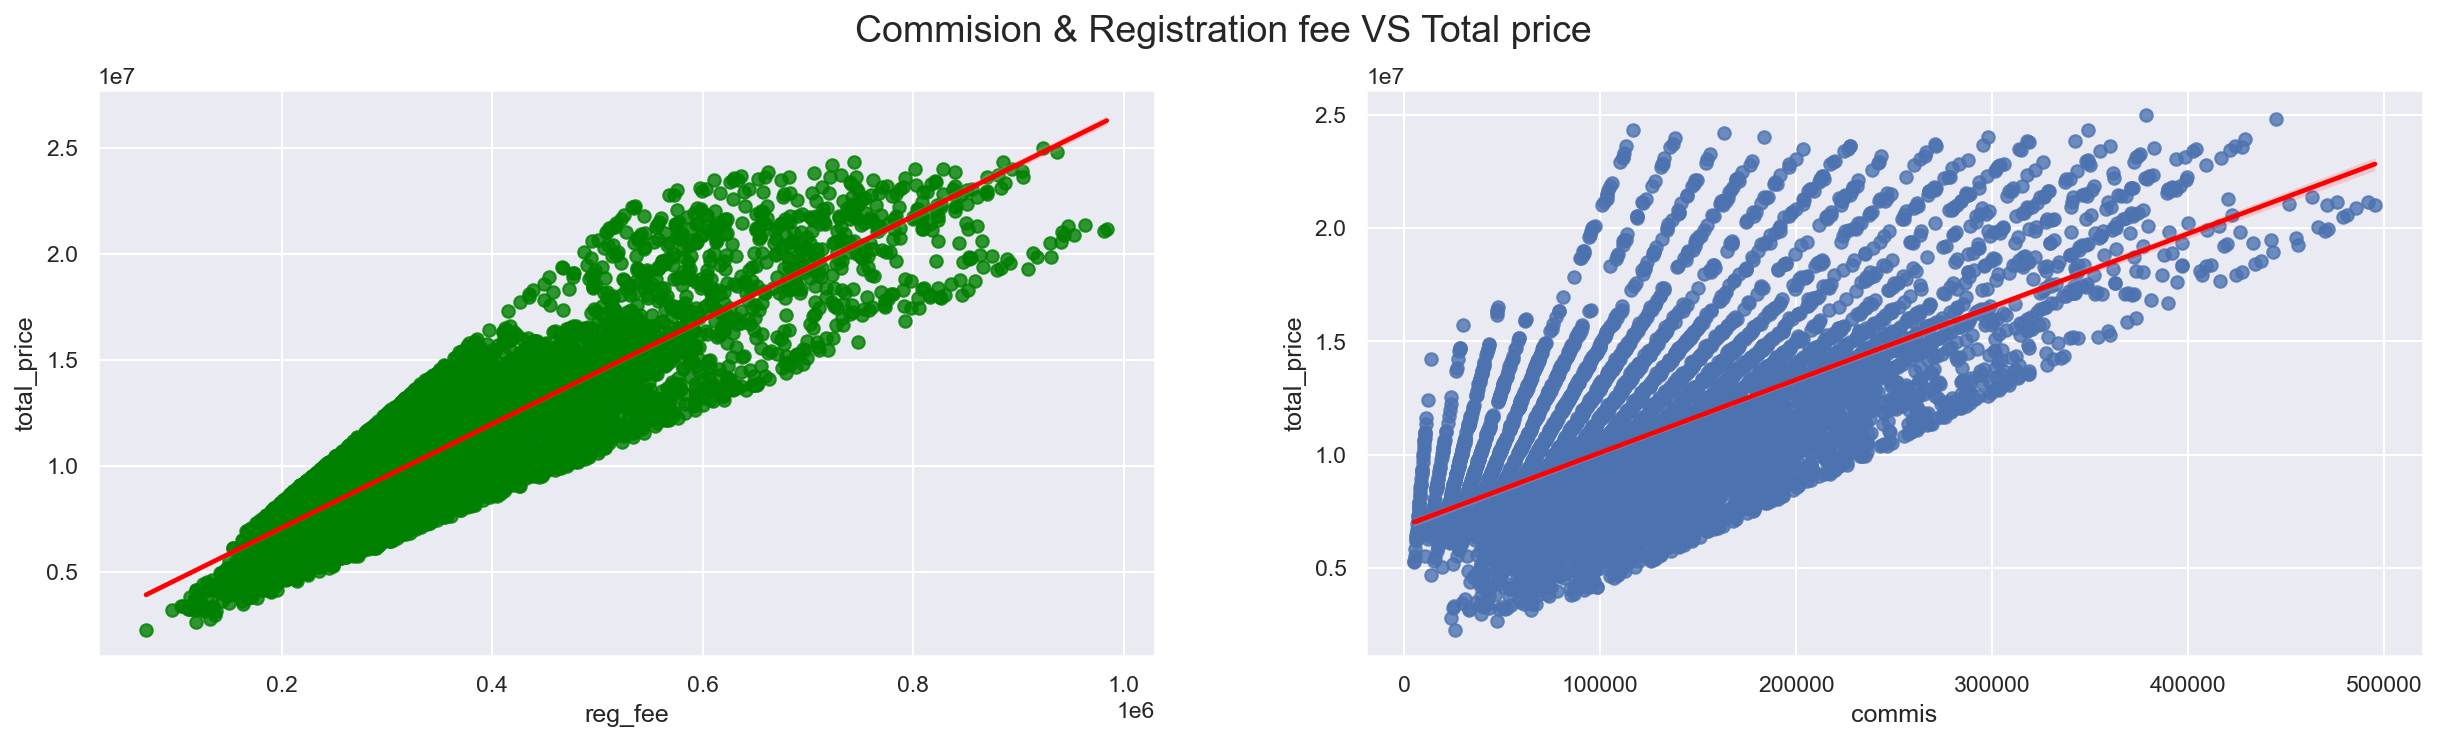

In [8]:
plt.figure(figsize=(20, 5), dpi=150)

plt.subplot(1,2,1)
sns.regplot(data.reg_fee, data.total_price, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.subplot(1,2,2)
sns.regplot(data.commis, data.total_price, line_kws={"color": "red"})

plt.suptitle("Commision & Registration fee VS Total price", fontsize=18)
plt.show()

### Categorical Columns

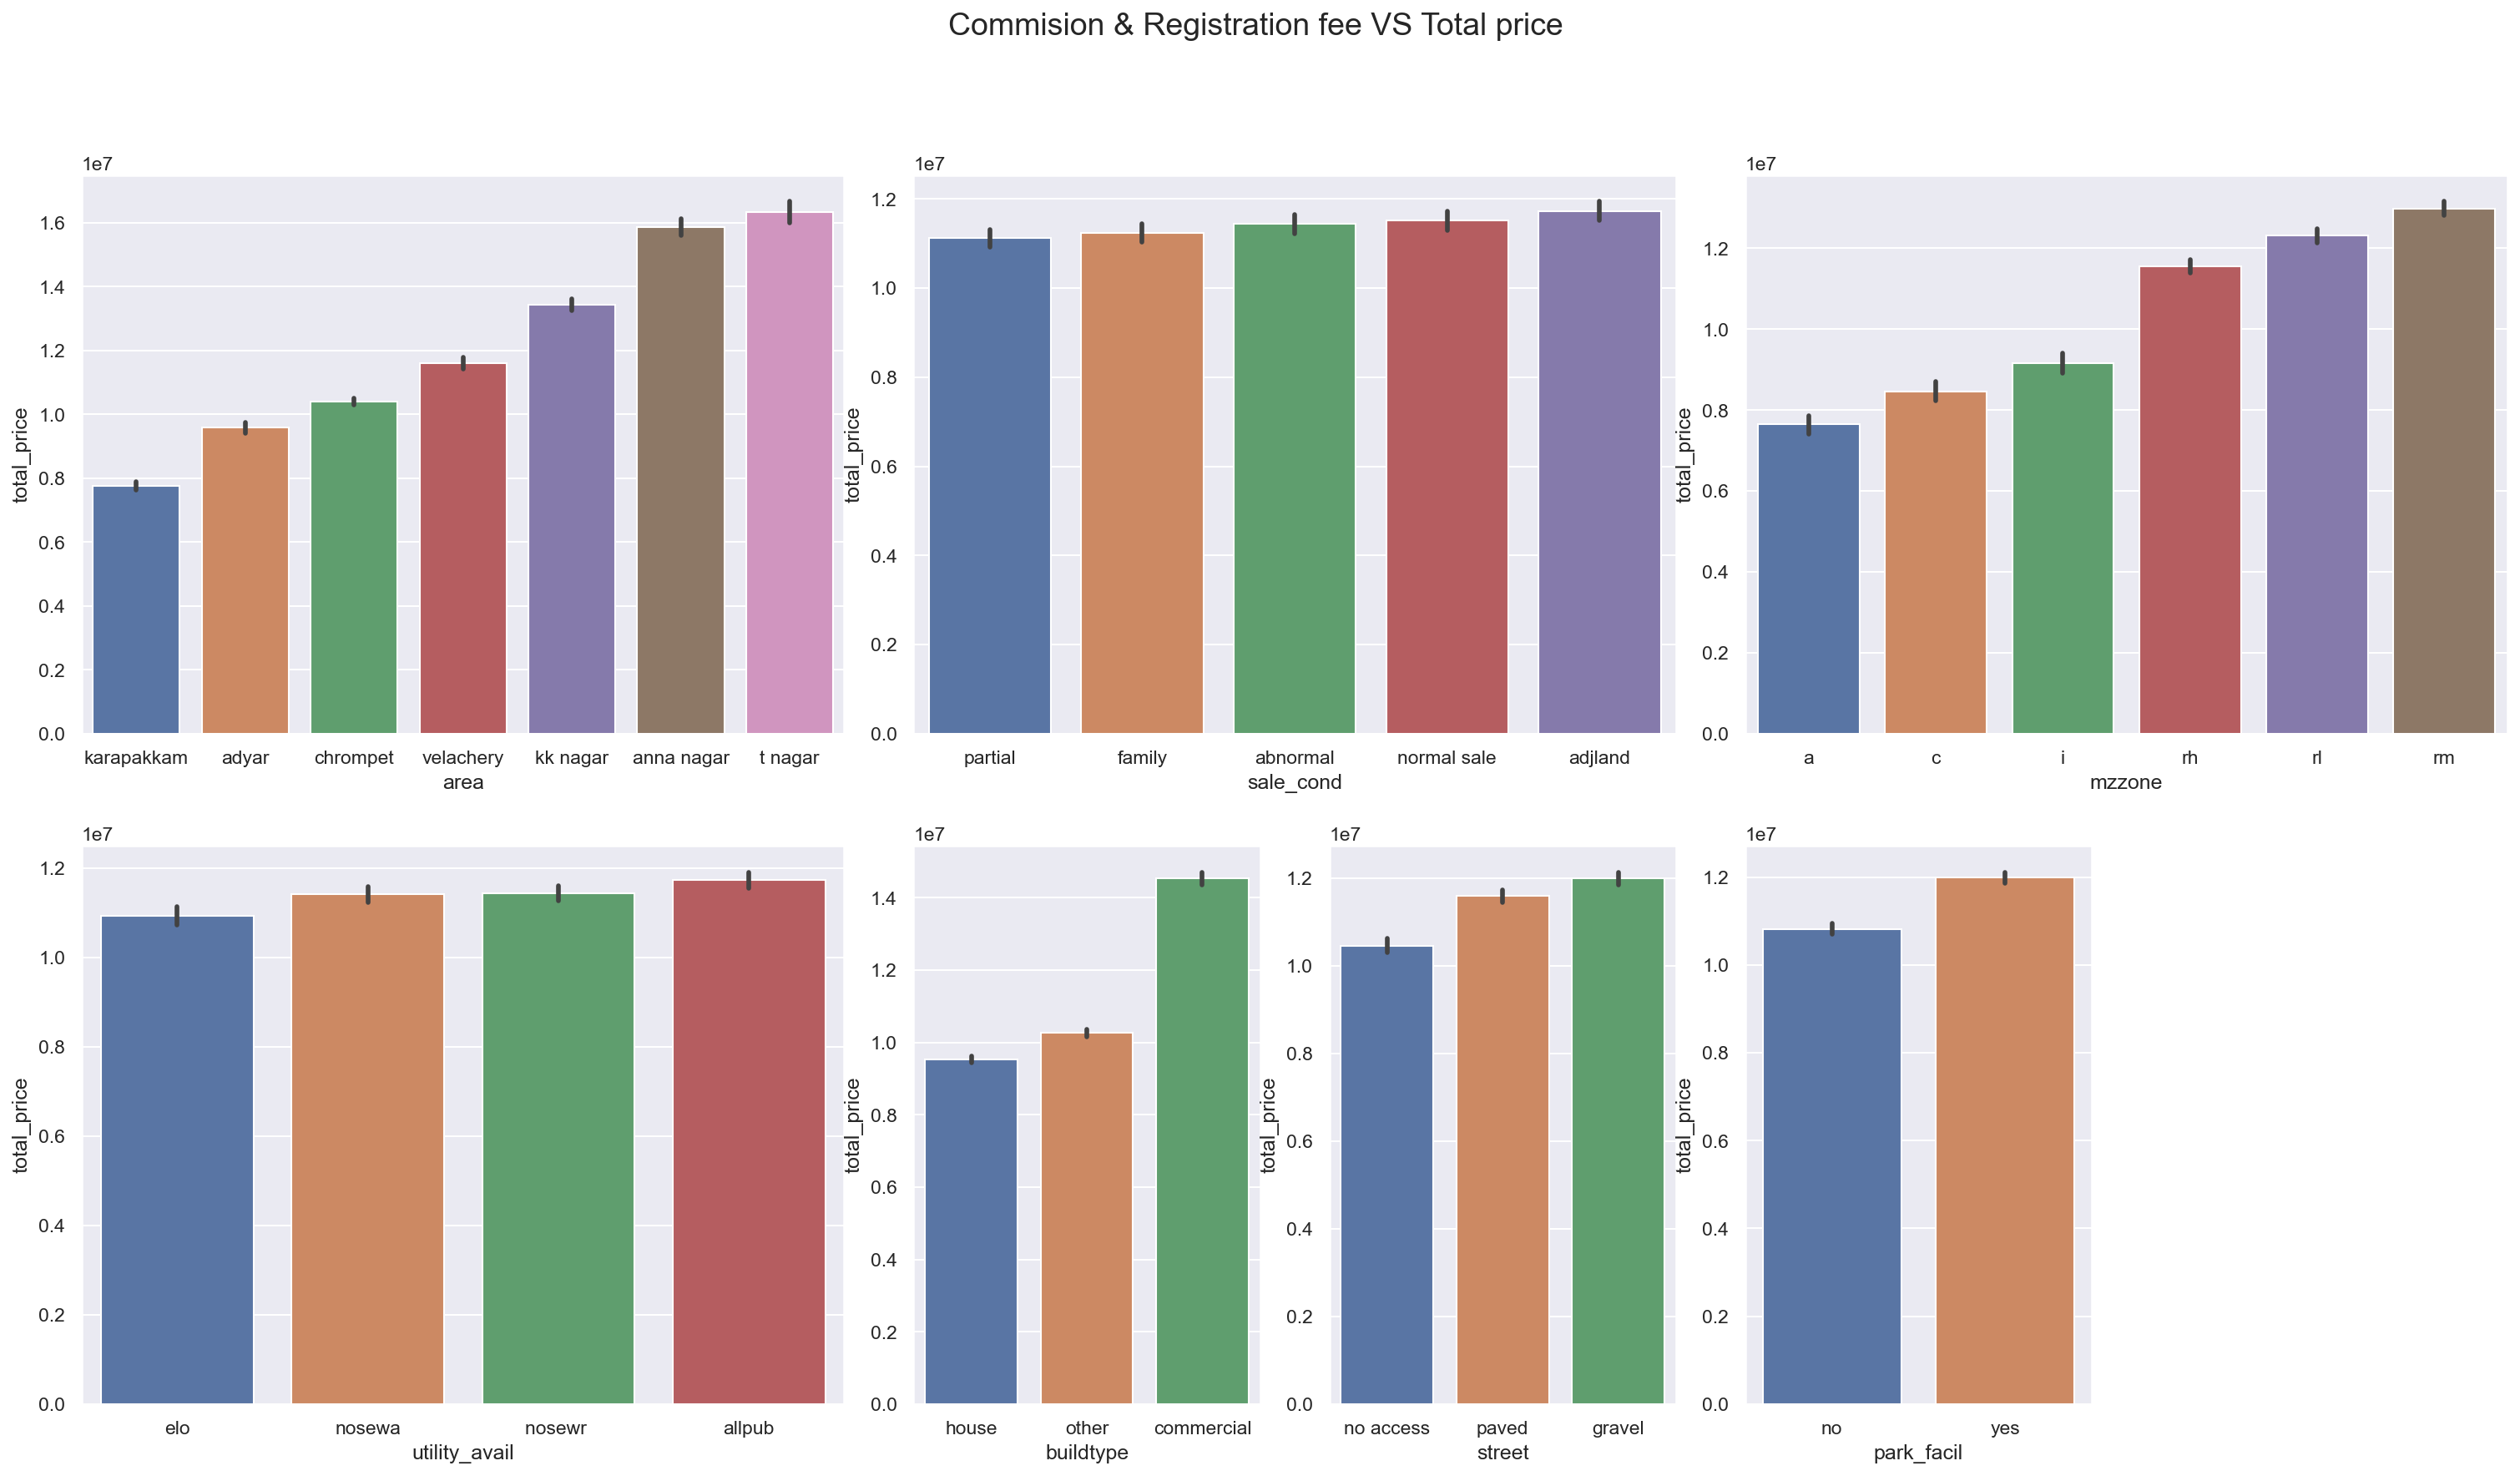

In [9]:
plt.figure(figsize=(25, 13), dpi=150)

plt.subplot2grid((2,6),(0,0),colspan=2)
sns.barplot(x=data.area,y=data.total_price,order=data.groupby('area')['total_price'].mean().reset_index().sort_values('total_price')['area'])

plt.subplot2grid((2,6),(0,2),colspan=2)
sns.barplot(x=data.sale_cond,y=data.total_price,order=data.groupby('sale_cond')['total_price'].mean().reset_index().sort_values('total_price')['sale_cond'])

plt.subplot2grid((2,6),(0,4),colspan=2)
sns.barplot(x=data.mzzone,y=data.total_price,order=data.groupby('mzzone')['total_price'].mean().reset_index().sort_values('total_price')['mzzone'])

plt.subplot2grid((2,6),(1,0),colspan=2)
sns.barplot(x=data.utility_avail,y=data.total_price,order=data.groupby('utility_avail')['total_price'].mean().reset_index().sort_values('total_price')['utility_avail'])

plt.subplot2grid((2,6),(1,2))
sns.barplot(x=data.buildtype,y=data.total_price,order=data.groupby('buildtype')['total_price'].mean().reset_index().sort_values('total_price')['buildtype'])

plt.subplot2grid((2,6),(1,3))
sns.barplot(x=data.street,y=data.total_price,order=data.groupby('street')['total_price'].mean().reset_index().sort_values('total_price')['street'])

plt.subplot2grid((2,6),(1,4))
sns.barplot(x=data.park_facil,y=data.total_price,order=data.groupby('park_facil')['total_price'].mean().reset_index().sort_values('total_price')['park_facil'])

plt.suptitle("Commision & Registration fee VS Total price", fontsize=18)
plt.show()

#### Interpretation:-

Here we can come to conclusion that:

1. In area when we sort column in respect of total_price we find good linear ordinal relation in this categorical feature and it will be important for us so we will keep it and do label encoding by preserving the order.
2. In sale_cond when we sort column in respect of total_price we find good linear ordinal relation in this categorical feature and it will be important for us so we will keep it and do label encoding by preserving the order.
3. In mzzone when we sort column in respect of total_price we find good linear ordinal relation in this categorical feature and it will be important for us so we will keep it and do label encoding by preserving the order.
4. In utility_avain when we sort column in respect of total_price we find good linear ordinal relation in this categorical feature and it will be important for us so we will keep it and do label encoding by preserving the order.
5. In buildtype when we sort column in respect of total_price we didn't find linear relation in this categorical feature but it maybe important for us so we will keep it and do OneHotEncoding on this column data.
6. In street when we sort column in respect of total_price we find good linear ordinal relation in this categorical feature and it will be important for us so we will keep it and do label encoding by preserving the order.
7. In park_facil when we sort column in respect of total_price we find good linear ordinal relation in this categorical feature and it will be important for us so we will keep it and do label encoding by preserving the order.

## Encoding

### OneHotEncoder

In [10]:
data = pd.get_dummies(data,columns=['buildtype'])

### Label Encoder (Mapping)

In [11]:
# Encoding the area column order-wise 
data.area = data.area.map({'karapakkam': 1,
                           'adyar': 2, 
                           'chrompet' : 3,
                           'velachery' : 4,
                           'kk nagar' : 5, 
                           'anna nagar' : 6,
                           't nagar' : 7})

# Encoding the sale_cond column order-wise 
data.sale_cond = data.sale_cond.map({'partial' : 1, 
                                     'family' : 2, 
                                     'abnormal' : 3, 
                                     'normal sale' : 4,
                                     'adjland' : 5})

# Encoding the park_facil column order-wise 
data.park_facil = data.park_facil.map({'yes':1,
                                       'no':0})

# Encoding the utility_avail column order-wise 
data.utility_avail = data.utility_avail.map({'elo' : 1, 
                                             'nosewa' : 2, 
                                             'nosewr ' : 3,
                                             'allpub' : 4})
                                          
# Encoding the street column order-wise 
data.street = data.street.map({'no access' : 1,
                               'paved' : 2, 
                               'gravel' : 3})


# Encoding the mzzone column order-wise 
data.mzzone = data.mzzone.map({'a' : 1,
                               'c' : 2,
                               'i' : 3,
                               'rl' : 5,
                               'rh' : 4,
                               'rm' : 6})

In [12]:
# Removing unnecessary columns and Rearranging the columns of dataframe 
data = data.reindex(columns = ['area', 'sale_cond', 'park_facil',
       'buildtype_commercial', 'buildtype_house','buildtype_other', 'utility_avail',
       'street', 'mzzone', 'property_age', 'int_sqft', 'dist_mainroad', 'n_bedroom',
       'n_bathroom', 'n_room', 'qs_rooms', 'qs_bathroom', 'qs_bedroom',
        'qs_overall', 'reg_fee', 'commis', 'sales_price', 'total_price'])

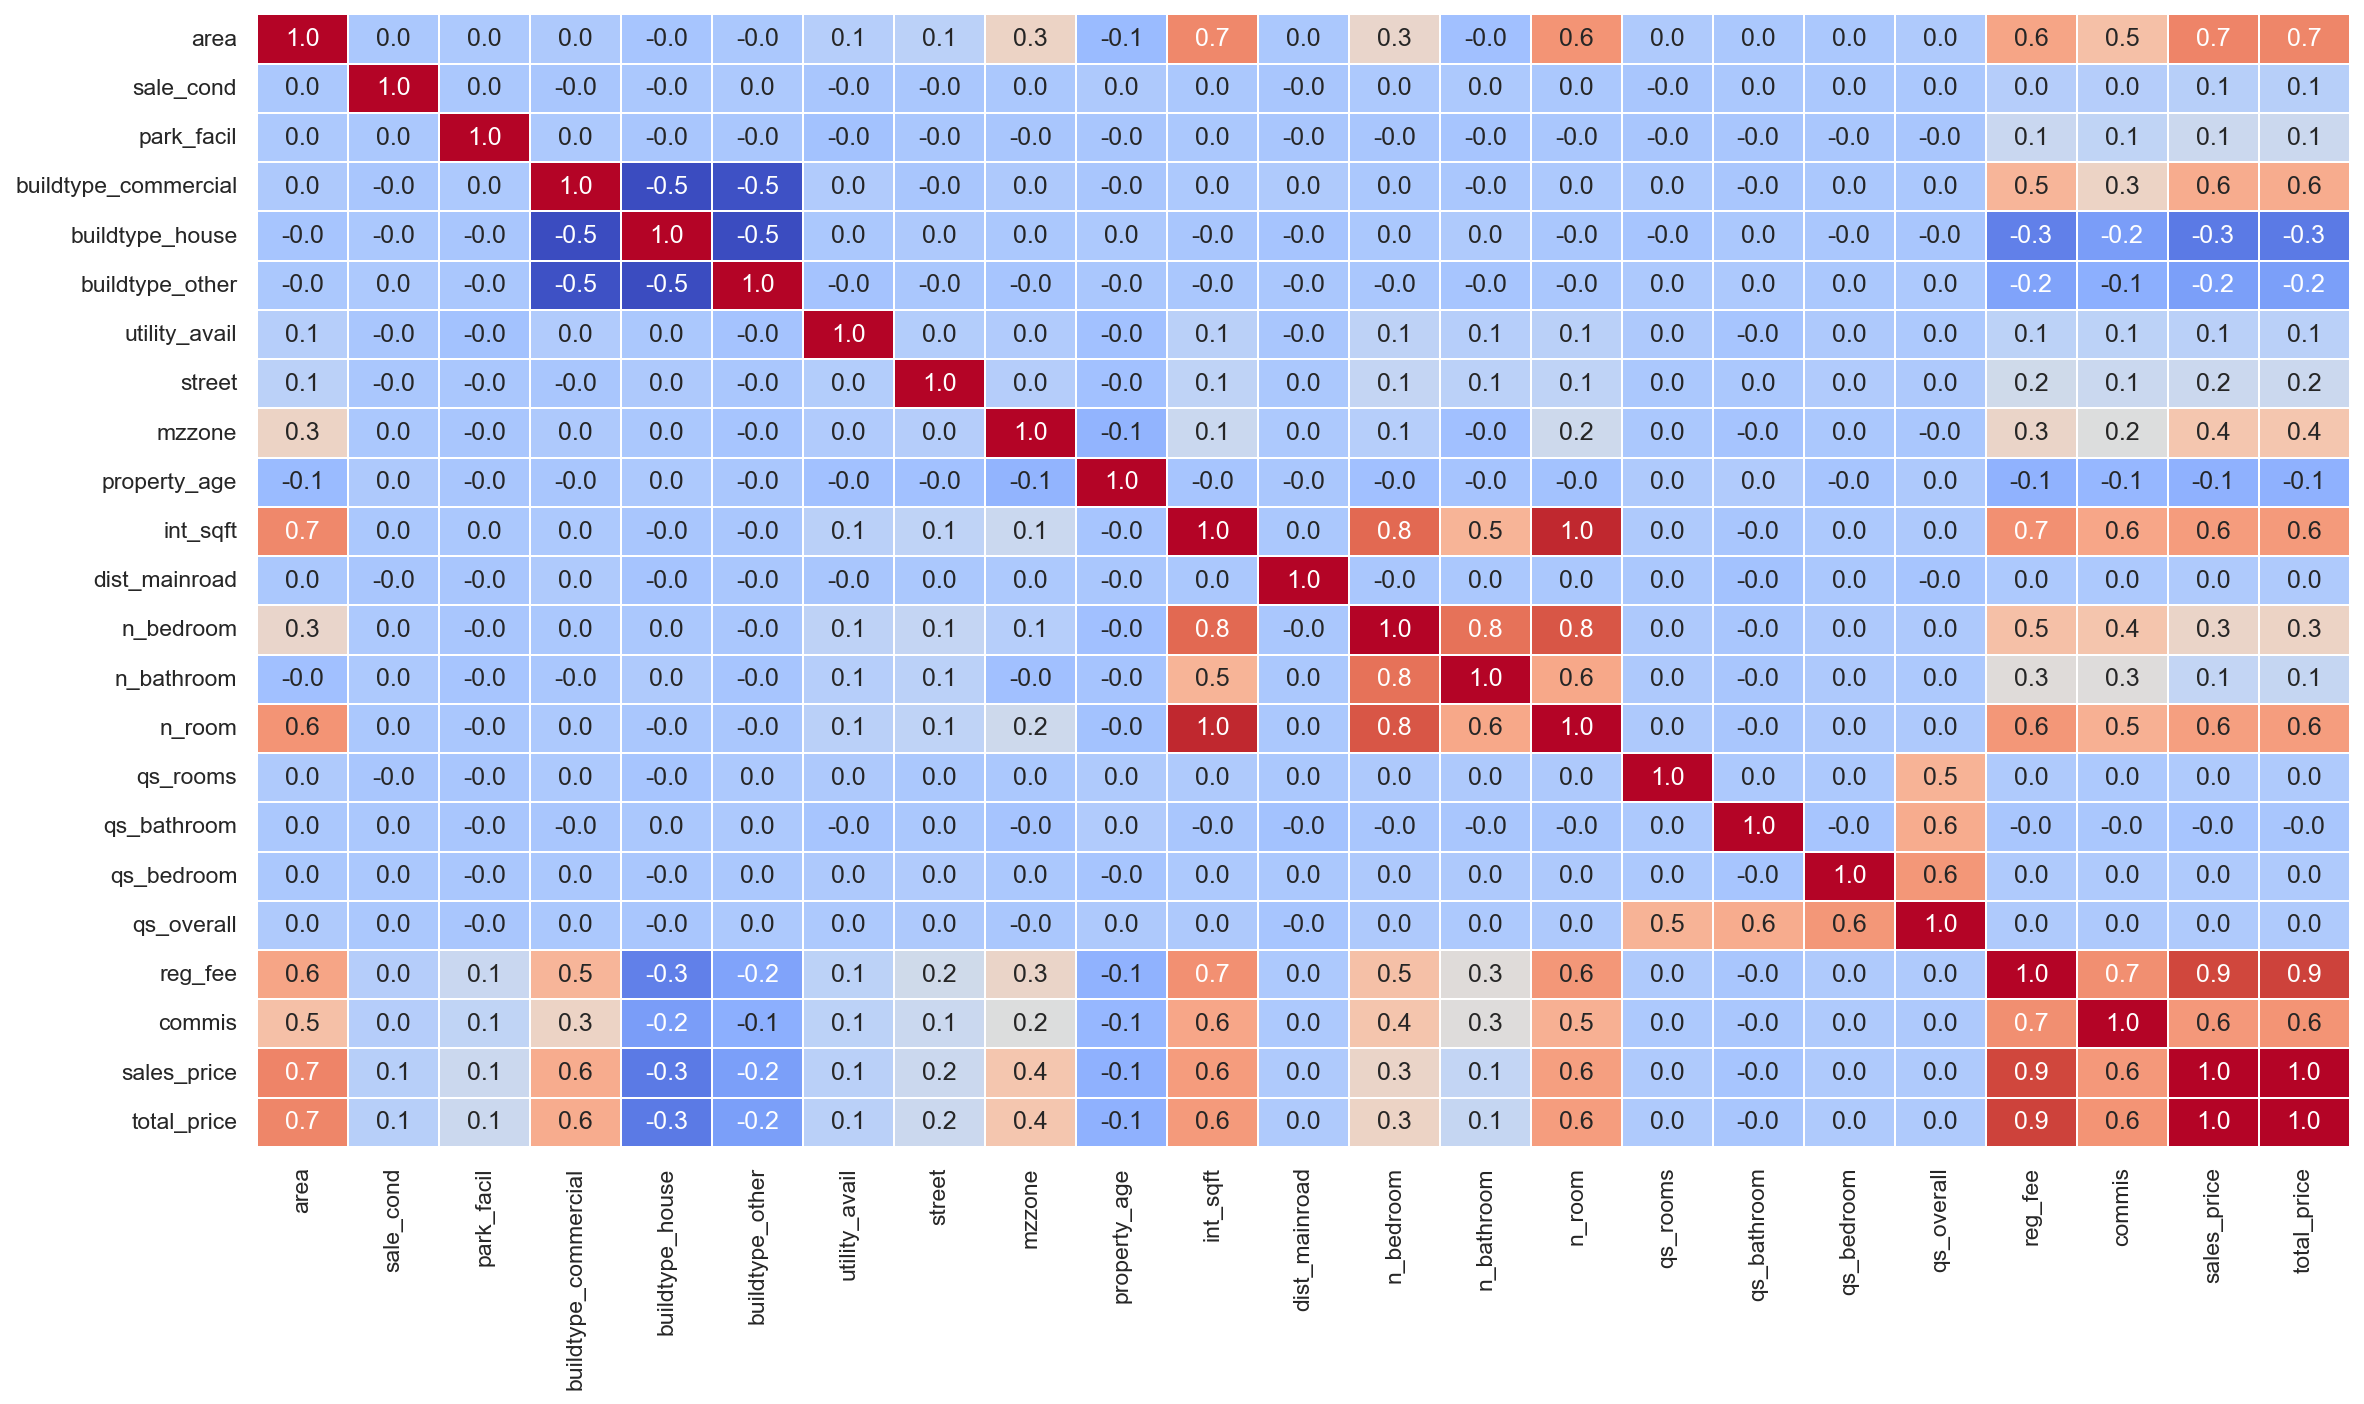

In [13]:
plt.figure(figsize=(18,10), dpi=150)
sns.heatmap(data.corr(method='pearson'), cbar=False, annot=True, fmt='.1f', linewidth=0.2, cmap='coolwarm');

#### Interpretation:-

Here after encoding all columns we can see that in categorical columns also there are some correlation between target and features as we can see there is a very good correlation between some columns of our data which are shown in red colour.

In [14]:
data.head(3)

area  sale_cond  park_facil  buildtype_commercial  buildtype_house  \
0     1          3           1                     1                0   
1     6          3           0                     1                0   
2     2          3           1                     1                0   

   buildtype_other  utility_avail  street  mzzone  property_age  int_sqft  \
0                0              4       2       1            44      1004   
1                0              4       3       4            11      1986   
2                0              1       3       5            20       909   

   dist_mainroad  n_bedroom  n_bathroom  n_room  qs_rooms  qs_bathroom  \
0            131          1           1       3       4.0          3.9   
1             26          2           1       5       4.9          4.2   
2             70          1           1       3       4.1          3.8   

   qs_bedroom  qs_overall  reg_fee  commis  sales_price  total_price  
0         4.9       4.330   380000  144400      7600000      8124400  
1         2.5       3.765   760122  304049     21717770     22781941  
2         2.2       3.090   421094   92114     13159200     13672408

In [15]:
# Removing unnecessary features thich has negligible relation with total_price
df = data.copy()
df.drop(['qs_overall', 'dist_mainroad', 'qs_overall','qs_rooms', 'qs_bathroom', 'qs_bedroom', 'reg_fee',	'commis'], axis=1, inplace=True)

In [16]:
input_cols = ['area', 'sale_cond', 'park_facil', 'buildtype_commercial',	'buildtype_house',
              'buildtype_other', 'utility_avail', 'street', 'mzzone', 'property_age',
              'int_sqft', 'n_bedroom', 'n_bathroom', 'n_room']

target_cols = 'sales_price'
target1_cols = 'total_price'

input = df[input_cols].copy()
target = df[target_cols].copy()
target1 = df[target1_cols].copy()

### Splitting the data for training and testing

In [17]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state = 7)

## Scaling

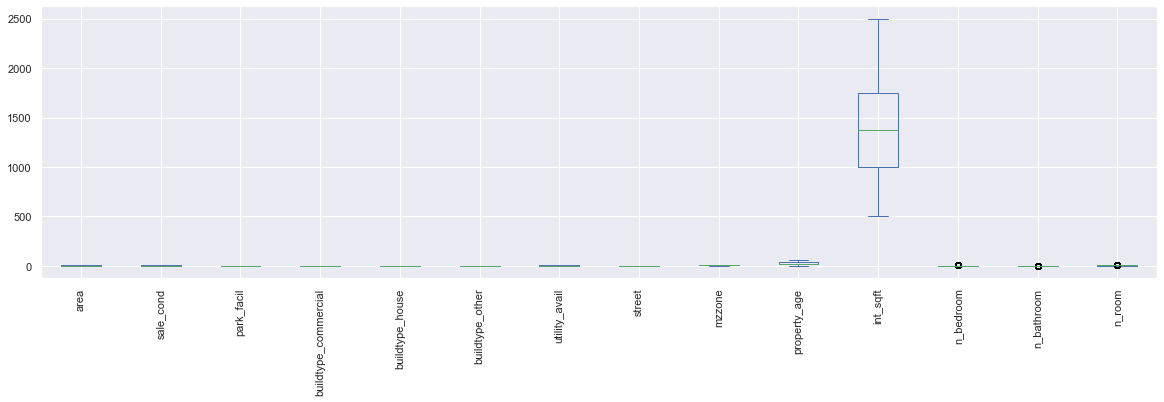

In [18]:
pd.DataFrame(X_train, columns=X_train.columns).plot.box(figsize=(20,5), rot=90)
plt.show()

#### Interpretation:-

Here we can clearly see in our features column int_sqft is the only feature which contains very large value and all the remaining of the feature column are pretty small.

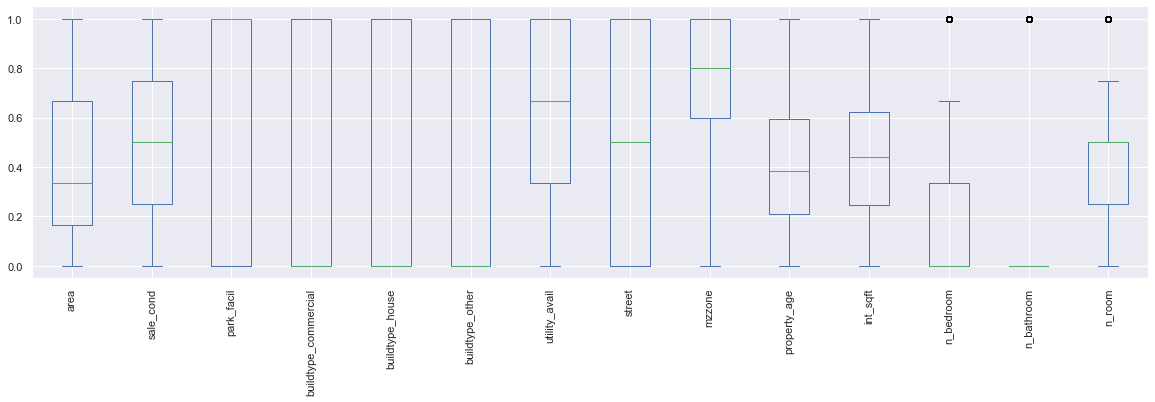

In [19]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=X_train.columns)
X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns=X_test.columns)
X_train_mm.plot.box(figsize=(20,5), rot=90)
plt.show()

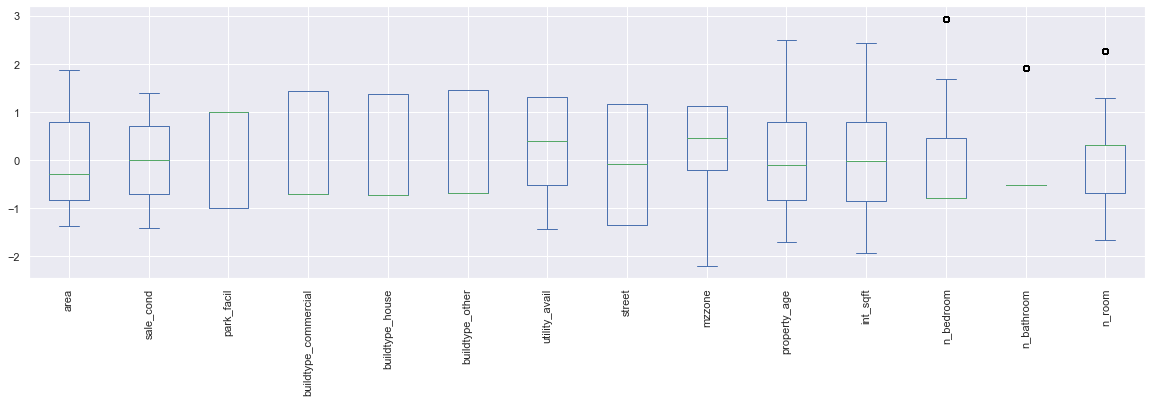

In [20]:
ss = StandardScaler().fit(X_train)
X_train_ss = ss.transform(X_train)
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = ss.transform(X_test)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)
X_train_ss.plot.box(figsize=(20,5), rot=90)
plt.show()

#### Interpretation:-

Here with the help of MinMaxScaler and StandardScaler we are trying to scale the data so that the spread of values between all the features become equal so that the model which train the data by using distance doesn't get very large values as their features.

## Model Training

### LinearRegression

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

# lr = LinearRegression()
lr.fit(X_train_ss, y_train)
y_predlrss = lr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predlrss))

# lr = LinearRegression()
lr.fit(X_train_mm, y_train)
y_predlrmm = lr.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predlrmm))

R2- SCORE: 0.923424259980204
R2- SCORE(Standardscaler): 0.9233987658411245
R2- SCORE(Minmaxscaled): 0.923424259980204


### KNearestNeighbors

Orange and Blue depict RSME for MinMaxScaler and blue


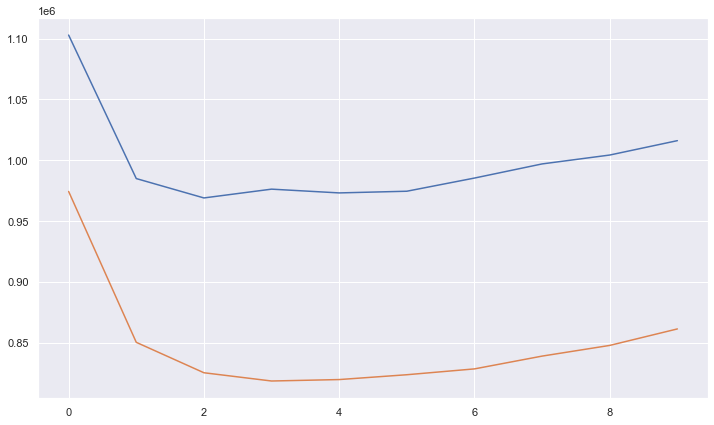

In [22]:
rmse_val = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_mm, y_train)
    pred=model.predict(X_test_mm)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
curve = pd.DataFrame(rmse_val)

rmse_val1 = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_ss, y_train)
    pred=model.predict(X_test_ss)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val1.append(error)
curve1 = pd.DataFrame(rmse_val1)

print('Orange and Blue depict RSME for MinMaxScaler and blue')
plt.figure(figsize=(12,7))
plt.plot(curve)
plt.plot(curve1)
plt.show()

In [23]:
knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(X_train, y_train)
y_predknn = knn.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_predknn))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_mm, y_train)
y_predknn_mm = knn.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predknn_mm))

knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_ss, y_train)
y_predknn_ss = knn.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predknn_ss))

R2- SCORE: 0.43314276289831866
R2- SCORE(Minmaxscaled): 0.9338292932490762
R2- SCORE(Standardscaler): 0.9527770963012473


### DecisionTree

In [24]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_dt))

dt.fit(X_train_mm, y_train)
y_pred_dtmm = dt.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_pred_dtmm))

dt.fit(X_train_ss, y_train)
y_pred_dtss = dt.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_dtss))

R2- SCORE: 0.9754087238428351
R2- SCORE(Minmaxscaled): 0.9760753396469557
R2- SCORE(Standardscaler): 0.9752858305882215


## Ensemble Learning

### Voting Regressor

In [25]:
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor(n_neighbors=100)
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators= 100, max_depth = 15, max_features='sqrt')
xg = xgb.XGBRegressor(learning_rate = .7, n_estimators=100, verbosity = 0)
gbr = GradientBoostingRegressor(learning_rate=.5)
etr = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

vr = VotingRegressor([('dt', dt), ('knn', knn), ('lr', lr), ('rf', rf), ('xg', xg), ('gbr', gbr), ('etr', etr)])

vr.fit(X_train, y_train);
y_pred_vr = vr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_vr))

vr.fit(X_train_ss, y_train);
y_pred_vrss = vr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_vrss))

vr.fit(X_train_mm, y_train);
y_pred_vrmm = vr.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_vr))

R2- SCORE: 0.9788849406969685
R2- SCORE(Standardscaler): 0.9896083057233733
R2- SCORE(MinMaxScaler): 0.9788849406969685


### Random Forest

In [26]:
rf = RandomForestRegressor(n_estimators= 100, max_depth = 15, max_features='sqrt')
rf.fit(X_train, y_train);
y_pred_rf = rf.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_rf))

rf.fit(X_train_mm, y_train);
y_pred_rfmm = rf.predict(X_test_mm)
print('R2- SCORE(minmaxscaled):', metrics.r2_score(y_test,y_pred_rfmm))

rf.fit(X_train_ss, y_train);
y_pred_rfss = rf.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_rfss))

R2- SCORE: 0.986899540308892
R2- SCORE(minmaxscaled): 0.9872835013653793
R2- SCORE(Standardscaler): 0.9870692451489388


### Extra Tree Regressor

In [27]:
etr = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_etr))

y_pred_etrmm = etr.predict(X_test_mm)
print('R2- SCORE(minmaxscaled):', metrics.r2_score(y_test,y_pred_etrmm))

y_pred_etrss = etr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_etrss))

R2- SCORE: 0.990943175687814
R2- SCORE(minmaxscaled): -3.4543088231107575
R2- SCORE(Standardscaler): -2.9228905733870048


### GradientBoostingRegressor

In [28]:
for lr in [0.1,0.3,0.5,0.8,1]:
  model= GradientBoostingRegressor(learning_rate=lr)
  model.fit(X_train, y_train)
  print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Test score : ", model.score(X_test,y_test))

Learning rate :  0.1  Train score :  0.9918884151594325  Test score :  0.9912206119939374
Learning rate :  0.3  Train score :  0.997053105407478  Test score :  0.9963507268229785
Learning rate :  0.5  Train score :  0.9977218437506626  Test score :  0.996930242282082
Learning rate :  0.8  Train score :  0.9977596041412032  Test score :  0.9961278133460032
Learning rate :  1  Train score :  0.9979310033973539  Test score :  0.9966592444389902


In [29]:
gbr = GradientBoostingRegressor(learning_rate=.5)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_gbr))

gbr.fit(X_train_mm, y_train)
y_pred_gbrmm = gbr.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_gbrmm))

gbr.fit(X_train_ss, y_train)
y_pred_gbrss = gbr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_gbrss))

R2- SCORE: 0.9969436721041329
R2- SCORE(MinMaxScaler): 0.9969315921858486
R2- SCORE(Standardscaler): 0.9969411861455915


### XGBoost

In [30]:
for lr in [0.2,0.5,0.7,0.8,1]:
  model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0)
  model.fit(X_train, y_train)
  print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Test score : ", model.score(X_test,y_test))

Learning rate :  0.2  Train score :  0.9992660104447402  Test score :  0.9973395154694097
Learning rate :  0.5  Train score :  0.9993955180513335  Test score :  0.9945515971835168
Learning rate :  0.7  Train score :  0.9994957696918326  Test score :  0.9923636387616817
Learning rate :  0.8  Train score :  0.9995920937678331  Test score :  0.991359456393351
Learning rate :  1  Train score :  0.9995570716304891  Test score :  0.9858694839363642


In [31]:
xg = xgb.XGBRegressor(learning_rate = .7, n_estimators=100, verbosity = 0)
xg.fit(X_train, y_train)
y_pred_gbr = xg.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_gbr))

xg.fit(X_train_mm, y_train)
y_pred_gbrmm = xg.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_gbrmm))

xg.fit(X_train_ss, y_train)
y_pred_gbrss = xg.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_gbrss))

R2- SCORE: 0.9923636387616817
R2- SCORE(MinMaxScaler): 0.9923606135074644
R2- SCORE(Standardscaler): 0.9922622947190022


#### Interpretation:-

Here after training all kinds of model we can see that MinMaxScaler or StandardScaler data model doesn't make much difference and they give very similar results.The results of all the models of the child being trained in this project I mentioned below:

* GradientBoostingRegressor give score of 0.99692 as R2-score.
* XGBRegressor gives score of 0.99236 as R2-score.
* ExtraTreesRegressor gives score of 0.99094 as R2-score.
* RandomForestRegressor gives score of 0.98741 as R2-score.
* LinearRegression gives score of 0.92342 as R2-score.
* KNeighborsRegressor gives score of 0.95277
* VotingRegressor gives score of 0.97889 as R2-score.
* DecisionTreeRegressor gives score of 0.97503 as R2-score.

## Conclusion:
Through this Machine Learning project we can conclude that there are so many aspects of training machine learning model. First, we have to clean the data and try to get all the features in a suitable format. There are many variables and features which play their role in setting the price of the house in this particular dataset. So we have to keep all the columns or features into consideration while training the model. After the training of machine learning model and here we train data with as many model as possible and try to get the best possible Root Squared score and at the end we finalise a model with highest Root Squared score for this data which gives a score of more than 99% (99.692% to be exact).